<a href="https://colab.research.google.com/github/JimKing100/Multiple_Offers/blob/master/model/XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Installs
%%capture
!pip install category_encoders==2.0.0

In [0]:
# Import libraries
import pandas as pd
import numpy as np

from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
import category_encoders as ce
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor


import category_encoders as ce
from joblib import dump

In [0]:
# Load the raw data
df = pd.read_csv('https://raw.githubusercontent.com/JimKing100/Multiple_Offers/master/data/Marin-MulitOffers-2015-2019-Final.csv')

In [4]:
df.head()

,Year,Area,Total Bathrooms,Bedrooms,Curr List Price,Number of Offers,Selling Price
0,2015,10,2,2,3200000,2,3400000
1,2015,10,3,3,3795000,2,3783000
2,2015,10,4,3,2675000,2,2675000
3,2015,10,3,4,2895000,2,3200000
4,2015,10,4,4,2795000,2,3100000


In [5]:
# Map the area codes to city names
dict = {10:'Belvedere', 20:'Bolinas', 30:'Corte Madera', 40:'Dillon Beach',
        50:'Fairfax', 70:'Greenbrae', 80:'Inverness', 90:'Kentfield',
        100:'Larkspur', 110:'Marshall', 120:'Mill Valley', 130:'Muir Beach',
        140:'Nicasio', 150:'Novato', 170:'Point Reyes', 180:'Ross',
        190:'San Anselmo', 200:'San Geronimo Valley', 210:'San Rafael',
        220:'Sausalito', 230:'Stinson Beach', 240:'Tiburon', 250:'Tomales'}

df = df.replace({'Area': dict}) 
df.head()

,Year,Area,Total Bathrooms,Bedrooms,Curr List Price,Number of Offers,Selling Price
0,2015,Belvedere,2,2,3200000,2,3400000
1,2015,Belvedere,3,3,3795000,2,3783000
2,2015,Belvedere,4,3,2675000,2,2675000
3,2015,Belvedere,3,4,2895000,2,3200000
4,2015,Belvedere,4,4,2795000,2,3100000


In [6]:
# Split into train and test - 2015-2018 in train, 2019 in test
low_cutoff = 2015
high_cutoff = 2019
train = df[(df['Year'] >= low_cutoff) & (df['Year'] < high_cutoff)]
test  = df[df['Year'] >= high_cutoff]
print(train.shape)
print(test.shape)

(3964, 7)
(776, 7)


In [7]:
# Split train into train and validation - 2015-2017 in train and 2018 in validation
cutoff = 2018
temp=train.copy()
train = temp[temp['Year'] < cutoff]
val  = temp[temp['Year'] >= cutoff]
print(train.shape, val.shape, test.shape)

(2973, 7) (991, 7) (776, 7)


In [8]:
# Encode and fit a XGBoost model
target = 'Selling Price'

features = train.columns.drop(target)
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    XGBRegressor(n_estimators=200, n_jobs=-1)
)

pipeline.fit(X_train, y_train)
dump(pipeline, 'pipeline.joblib')
y_pred = pipeline.predict(X_val)

# Print metrics for validation 
val_mse = mean_squared_error(y_val, y_pred)
val_rmse = np.sqrt(val_mse)
val_mae = mean_absolute_error(y_val, y_pred)
val_r2 = r2_score(y_val, y_pred)
print('Validation Mean Absolute Error:', val_mae)
print('Validation R^2:', val_r2)
print('\n')

ty_pred = pipeline.predict(X_test)

# Print metrics for test
test_mse = mean_squared_error(y_test, ty_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, ty_pred)
test_r2 = r2_score(y_test, ty_pred)
print('Test Mean Absolute Error:', test_mae)
print('Test R^2:', test_r2)


[17:30:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Validation Mean Absolute Error: 71851.57451437942
Validation R^2: 0.9726460777954237


Test Mean Absolute Error: 68002.4604945232
Test R^2: 0.983941073468622


In [9]:
# Add the prediction, difference and address to the final dataframe
final = test.copy()
final = final.reset_index()
final['Prediction'] = ty_pred
final['Difference'] = final['Prediction'] - final['Selling Price']
final['Prediction'] = final['Prediction'].astype(int)
final['Difference'] = final['Difference'].astype(int)
print(final.shape)
final.head()

(776, 10)


,index,Year,Area,Total Bathrooms,Bedrooms,Curr List Price,Number of Offers,Selling Price,Prediction,Difference
0,3964,2019,Belvedere,2,2,2895000,2,2900000,2963013,63013
1,3965,2019,Belvedere,2,3,2100000,2,1815000,2054723,239723
2,3966,2019,Belvedere,3,3,3995000,2,3978000,3905144,-72855
3,3967,2019,Belvedere,3,3,2895000,2,3000000,2951627,-48372
4,3968,2019,Belvedere,3,4,3800000,2,4235000,3660602,-574397


In [15]:
# Calculate the metrics
final['Pred Percent'] = final['Difference']/final['Prediction']
pred_median_error = final['Pred Percent'].median()
pred_one_percent = (final['Pred Percent'][(final['Pred Percent'] >= -.01) &
                                          (final['Pred Percent'] <= .01)].count())/final.shape[0]

pred_five_percent = (final['Pred Percent'][(final['Pred Percent'] >= -.05) &
                                           (final['Pred Percent'] <= .05)].count())/final.shape[0]

pred_ten_percent = (final['Pred Percent'][(final['Pred Percent'] >= -.10) &
                                          (final['Pred Percent'] <= .10)].count())/final.shape[0]

pred_win_percent = (final['Pred Percent'][(final['Pred Percent'] >= 0)].count())/final.shape[0]

print('Median Error - %.4f%%' % (pred_median_error * 100))
print('Prediction Within 1 percent - %.4f%%' % (pred_one_percent * 100))
print('Prediction Within 5 percent - %.4f%%' % (pred_five_percent * 100))
print('Prediction Within 10 percent - %.4f%%' % (pred_ten_percent * 100))
print('Winning Prediction - %.4f%%' % (pred_win_percent * 100))

Median Error - 0.4881%
Prediction Within 1 percent - 14.6907%
Prediction Within 5 percent - 69.7165%
Prediction Within 10 percent - 91.4948%
Winning Prediction - 53.4794%


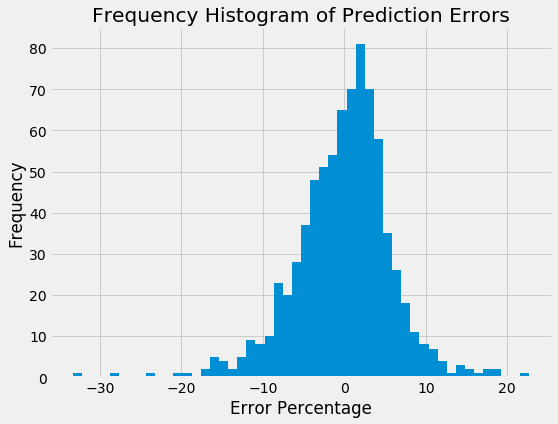

In [14]:
# Graph the prediction errors
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('fivethirtyeight')

fig, ax = plt.subplots(figsize=(8,6))

plt.hist((final['Pred Percent'] * 100), bins=50)
plt.gca().set(title='Frequency Histogram of Prediction Errors', xlabel='Error Percentage', ylabel='Frequency');